In [137]:
#import pyactup as pau
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import seaborn as sns

import random
import math
from math import log
from math import exp
from pybads import BADS
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FixedFormatter
sns.set_style("ticks")

# Free Energy Memory Models


# Cepeda's Data

Cepeda et al's (2008) is perhaps the most extensive examination of the spacing effect. In Cepeda's data, participants were asked to study trivia questions and answers ("Which country consumes more hot sauce? Norway"). Each question was studied twice, at times $t_1$ and $t_2$ and tested once, at time $t_3$. The space between $t_1$ and $t_2$ is the _spacing_, while the space between $t_2$ and $t_3$ is the _Retention Interval_ (RI). 

In [138]:
cepeda = pd.read_csv("cepeda_recall.csv")
cepeda

,RI,Spacing,Accuracy
0,35,0.00256,0.522955
1,35,1.00000,0.690765
2,35,4.00000,0.738259
3,35,7.00000,0.804749
4,35,11.00000,0.822164
5,35,21.00000,0.758839
6,35,105.00000,0.598945
7,7,0.00256,0.887071
8,7,1.00000,0.978892
9,7,2.00000,0.956728


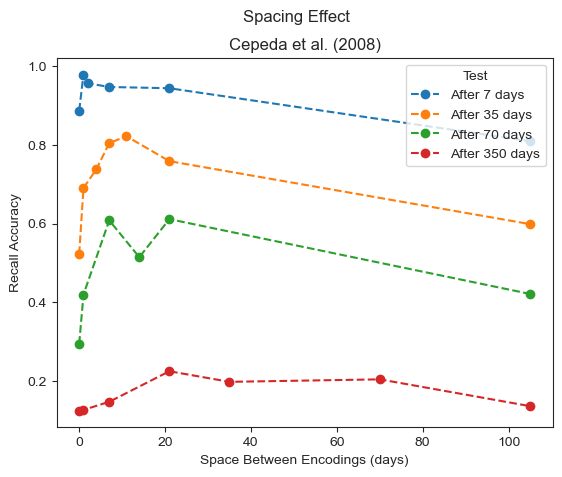

In [139]:
fig, ax = plt.subplots()
cepeda.groupby("RI").plot(x="Spacing", y="Accuracy", marker="o", ax=ax, linestyle="--")
ax.legend(["After %d days" % (x,) for x in [7, 35, 70, 350]], loc="upper right", title="Test")
ax.set_ylabel("Recall Accuracy")
ax.set_xlabel("Space Between Encodings (days)")
ax.set_title("Cepeda et al. (2008)")
fig.suptitle("Spacing Effect")
plt.show()

# Object-based Implementation

## Anderson & Schooler (1991)

Let's start with an abstraction: An ACT-R-style memory system.

In [140]:
class Memory:
    """An ACT-R Memory"""
    def __init__(self, d=0.3):
        self.d = d
        self.traces = []

    def add_trace(self, trace):
        """Adds a trace"""
        self.traces.append(trace)

    def add_traces(self, traces):
        """Adds multiple traces"""
        for t in traces:
            self.add_trace(t)

    def compute_trace_sum(self, time):
        """Computes the internal contributions of all traces"""
        d = self.d
        odds = 0.0
        for trace in self.traces:
            if trace < time:
                t = time - trace
                odds += t**-d
        return odds
    
    def activation(self, time):
        """Returns the activation of the memory at time t"""
        odds = self.compute_trace_sum(time)

        if odds == 0:
            return np.nan
        else:
            A = np.log(odds)
            if np.isinf(A):
                return np.nan
            else:
                return A

    def retrieval_probability(self, time):
        A = self.activation(time)
        return 1 / (1 + exp(-A))

    def reset(self):
        """Resets traces"""
        self.traces = []

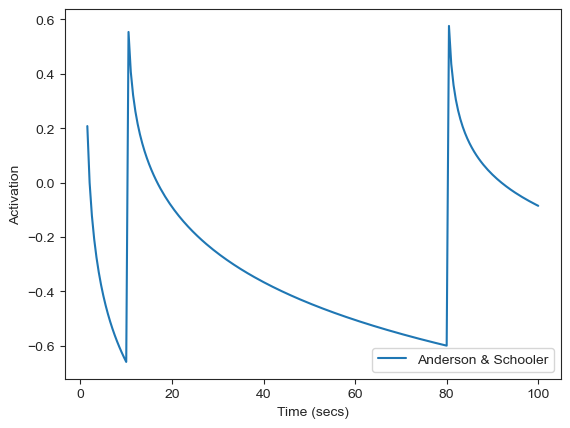

In [141]:
test_traces = [1, 10, 80]
m = Memory()
m.add_traces(test_traces)

time = np.linspace(0, 100, 201)
actr = [m.activation(t) for t in time]
prob = [m.retrieval_probability(t) for t in time]
plt.plot(time, actr, label="Anderson & Schooler")
plt.legend()
plt.xlabel("Time (secs)")
plt.ylabel("Activation")
plt.show()

## Pavlik & Anderson's (2005)

In [142]:
class PavlikMemory(Memory):
    """A Memory with Pavlik & Anderson's equation"""
    def __init__(self, d=0.3, c=0.25):
        super().__init__(d)
        self.c = c
        self.decays = []
        
    def add_trace(self, trace):
        d = self.d
        c = self.c
        if len(self.traces) == 0:
            self.decays.append(d)
        else:
            A  = self.activation(trace)
            new_d = c * np.exp(A) + d
            self.decays.append(new_d)
        self.traces.append(trace)

    def compute_trace_sum(self, time):
        """Returns the activation of the memory at time t"""
        odds = 0.0
        for trace, decay in zip(self.traces, self.decays):
            if trace < time:
                t = time - trace
                odds += t**-decay
        return odds

    def reset(self):
        super().reset()
        self.decays = []


Quick visualization

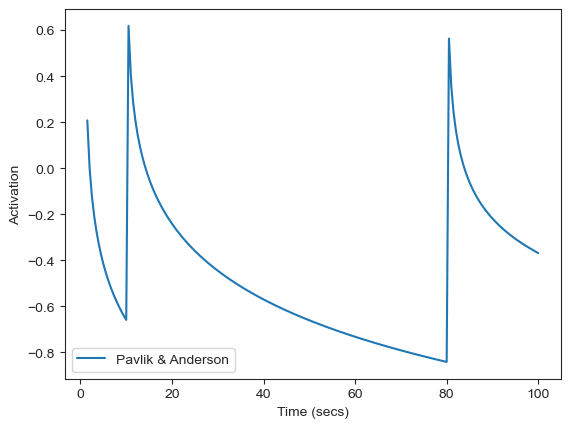

In [143]:
pam = PavlikMemory()
pam.add_traces(test_traces)

time = np.linspace(0, 100, 201)
pavlik = [pam.activation(t) for t in time]
plt.plot(time, pavlik, label="Pavlik & Anderson")
plt.legend()
plt.xlabel("Time (secs)")
plt.ylabel("Activation")
plt.show()

## Free Energy Models

These models add _weights_ to each trace; each weight is computed at the moment of the trace creation.

In [144]:
class WeightedMemory(Memory):
    """A weighted memory"""
    def __init__(self, d=0.3):
        super().__init__(d)
        self.weights = []

    def add_trace(self, trace):
        """Adds a trace"""
        w = self.compute_weight(trace)
        super().add_trace(trace)
        self.weights += [w]
    
    def compute_weight(self, trace):
        return 1

    def compute_trace_sum(self, time):
        """Returns activation at time t"""
        d = self.d
        odds = 0.0
        for w, trace in zip(self.weights, self.traces):
            if trace < time:
                t = time - trace
                odds += w * t**-d
        return odds

    def reset(self):
        super().reset()
        self.weights = []

### Surprisal Model

In [145]:
class SurprisalMemory(WeightedMemory):
    """An FEP memory with surprisal weights"""
    def __init__(self, d=0.3, w1=20):
        super().__init__(d)
        self.w1 = w1

    def compute_weight(self, trace):
        """Computes weights based on surprisal"""
        w = 0
        if len(self.traces) == 0:
            w = self.w1
        else:
            A = self.activation(trace)
            w = np.log(1 + np.exp(-A))
        return w

and here is a test

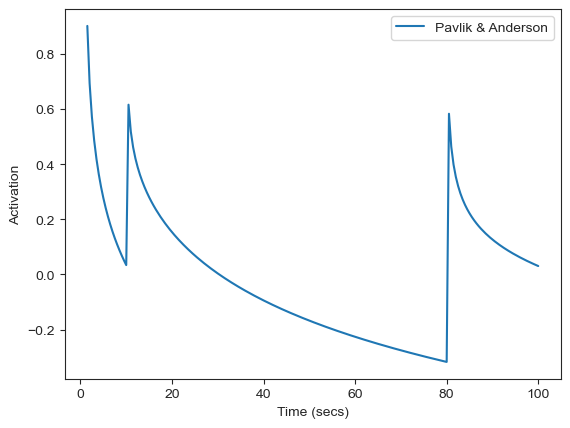

In [146]:
sm = SurprisalMemory(w1=2)
sm.add_traces(test_traces)

time = np.linspace(0, 100, 201)
surprisal = [sm.activation(t) for t in time]
plt.plot(time, surprisal, label="Pavlik & Anderson")
plt.legend()
plt.xlabel("Time (secs)")
plt.ylabel("Activation")
plt.show()

### Homeostasis Model

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

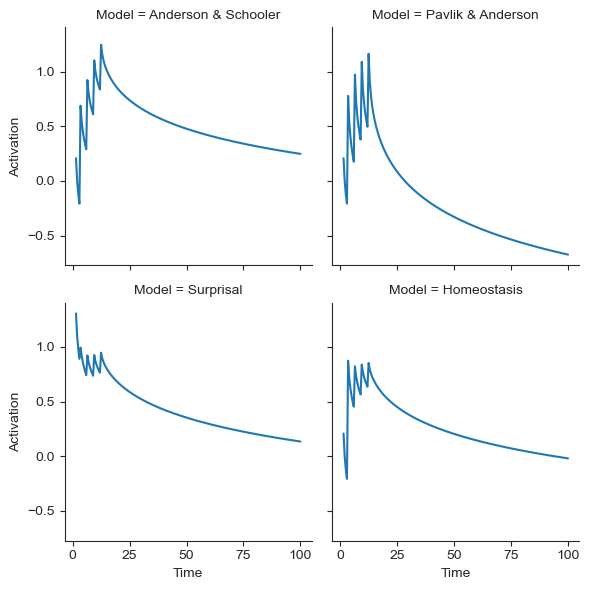

In [147]:
class HomestaticMemory(WeightedMemory):
    """A homestatic memory"""
    def __init__(self, d=0.3, w1=1, delta=1, k=0):
        super().__init__(d)
        self.w1 = 1
        self.k = k
        self.delta = delta
        self.traces = []
        self.weights = []

    def compute_weight(self, trace):
        """Computes weights based on surprisal"""
        w = 0
        if len(self.traces) == 0:
            w = self.w1
        else:
            dt = self.delta
            K = self.k
            A = self.activation(trace + dt)
            w = np.exp(K) - A
        return w

    
m = Memory()
pam = PavlikMemory(c=0.25)
sm = SurprisalMemory(w1=3)
hm = HomestaticMemory(w1=3, delta = 1, k=0)

test_traces1 = [1, 3, 6, 9, 12]
test_traces2 = [1, 10, 90]


for tr in test_traces1:
    m.add_trace(tr)
    pam.add_trace(tr)
    sm.add_trace(tr)
    hm.add_trace(tr)
    
time = np.linspace(0, 100, 201)
actr = [m.activation(t) for t in time]
pvlk = [pam.activation(t) for t in time]
srpr = [sm.activation(t) for t in time]
hmstc = [hm.activation(t) for t in time]

actr_df = pd.DataFrame({'Time' : time, 'Activation' : actr, "Model" : "Anderson & Schooler"})
pvlk_df = pd.DataFrame({'Time' : time, 'Activation' : pvlk, "Model" : "Pavlik & Anderson"})
srpr_df = pd.DataFrame({'Time' : time, 'Activation' : srpr, "Model" : "Surprisal"})
hmstc_df = pd.DataFrame({'Time' : time, 'Activation' : hmstc, "Model" : "Homeostasis"})

df = pd.concat([actr_df, pvlk_df, srpr_df, hmstc_df])

g = sns.FacetGrid(df, col="Model", col_wrap=2)
g.map(sns.lineplot, "Time", "Activation")

### Relationship between the two 

/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_75686/3863879213.py:2: RuntimeWarning: invalid value encountered in log
  return np.log((2 - weight) / (1 - weight))
/var/folders/99/15zptlt56d7f2h8pxlt9k4000000gn/T/ipykernel_75686/3863879213.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log((2 - weight) / (1 - weight))


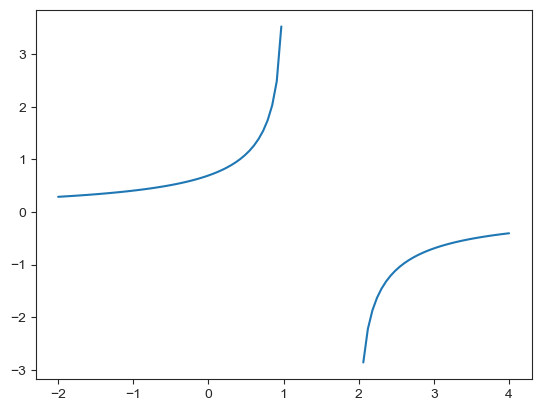

In [148]:
def homeostatic_to_surprisal(weight):
    return np.log((2 - weight) / (1 - weight))

w_hmstc = np.linspace(-2, 4, 100)
w_srprl = [homeostatic_to_surprisal(w) for w in w_hmstc]

plt.plot(w_hmstc, w_srprl, "-", label="Theory")

# Testing API

We need an API for testing generic conditions

In [149]:
class Experiment:
    """An abstraction for a memory experiment"""
    def __init__(self):
        self.conditions = [] 
        
    def add_condition(self, study_times, test_time):
        self.conditions.append([study_times], test_time)

    def run(self, model):
        """Runs the given model across all conditions"""
        model.reset()
        results = {}
        for condition in self.conditions:
            study_times, test_time = condition
            model.add_traces(study_times)
            accuracy = model.retrieval_probability(test_time)
            results[condition] = accuracy

        return results

In [150]:
cepeda_exp = Experiment()
for 

SyntaxError: invalid syntax (1888130163.py, line 2)